In [46]:
import numpy as np
from numpy import newaxis
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Conv1D, MaxPool1D, Flatten, BatchNormalization, Dropout, Dense
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras import optimizers
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
data_path = '/content/included_2016_nn_dataset_input.xlsx'
aglo_data = pd.read_excel(data_path, sheet_name="Sheet1")
data_numeric = aglo_data.apply(pd.to_numeric, errors='coerce').dropna()
X = data_numeric.drop(columns=["Sinter.SP4.Rozsev.Under5mm.%"])
y = data_numeric["Sinter.SP4.Rozsev.Under5mm.%"]

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
n_features = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], n_features, 1)
X_val = X_val.reshape(X_val.shape[0], n_features, 1)
X_test = X_test.reshape(X_test.shape[0], n_features, 1)
print("X_train shape:", X_train.shape)  # Check the shape of X_train
print("X_train shape after reshaping:", X_train.shape)

X_train shape: (1617, 19, 1)
X_train shape after reshaping: (1617, 19, 1)


In [ ]:
model = Sequential()
model.add(Input(shape=(n_features, 1)))
model.add(Conv1D(32, kernel_size=3, activation="relu", padding = 'same'))
model.add(Conv1D(64, kernel_size=2, activation="relu", padding = 'same'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(128, kernel_size=1, activation="relu", padding = 'same'))
model.add(MaxPool1D(pool_size=1))
model.add(Conv1D(64, kernel_size=2, activation="relu", padding = 'same'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(10, activation="relu"))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 19, 32)            128       
                                                                 
 conv1d_16 (Conv1D)          (None, 19, 64)            4160      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 9, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 9, 128)            8320      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 9, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 9, 64)            

In [ ]:
#learning_rate = 0.001  # Example learning rate value

#optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=30,
    epochs=200
)

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

Epoch 1/200
54/54 [==============================] - 2s 12ms/step - loss: 43.8098 - val_loss: 18.2359
Epoch 2/200
54/54 [==============================] - 1s 10ms/step - loss: 13.8936 - val_loss: 18.1517
Epoch 3/200
54/54 [==============================] - 1s 11ms/step - loss: 13.6660 - val_loss: 17.2308
Epoch 4/200
54/54 [==============================] - 0s 9ms/step - loss: 13.8971 - val_loss: 17.3363
Epoch 5/200
54/54 [==============================] - 1s 10ms/step - loss: 13.4923 - val_loss: 17.1041
Epoch 6/200
54/54 [==============================] - 0s 8ms/step - loss: 13.2895 - val_loss: 17.4303
Epoch 7/200
54/54 [==============================] - 0s 9ms/step - loss: 13.1115 - val_loss: 17.1884
Epoch 8/200
54/54 [==============================] - 0s 8ms/step - loss: 13.0811 - val_loss: 17.3241
Epoch 9/200
54/54 [==============================] - 1s 14ms/step - loss: 13.4941 - val_loss: 18.3365
Epoch 10/200
54/54 [==============================] - 1s 14ms/step - loss: 13.0143 - v

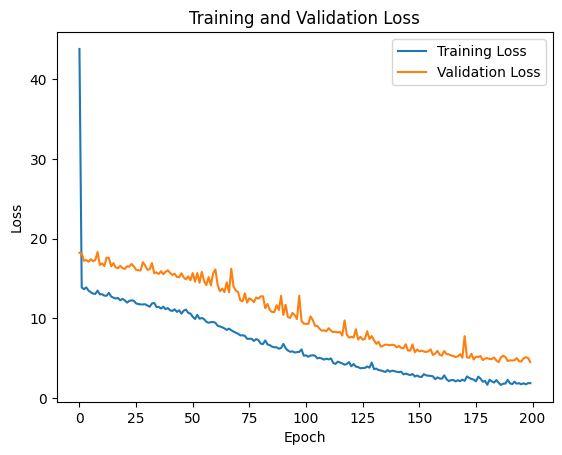

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

19/19 [==============================] - 0s 3ms/step


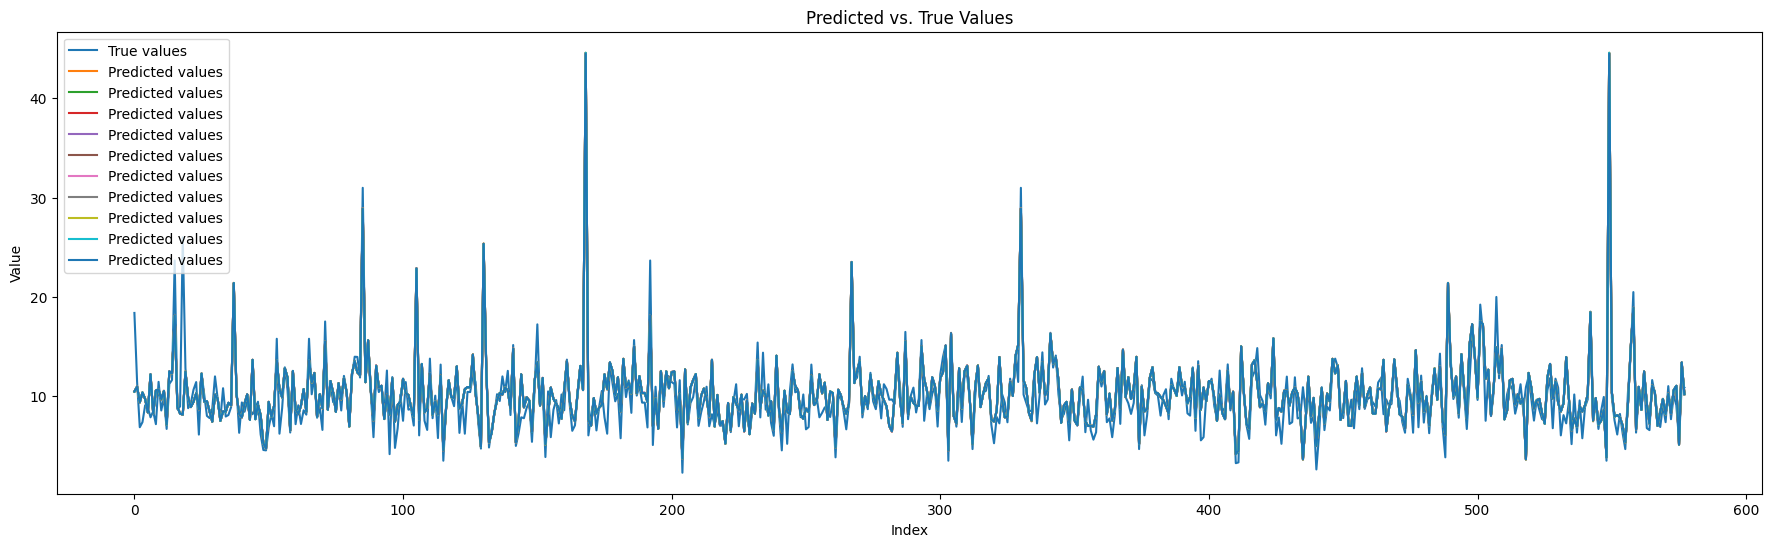

In [52]:
predicted_values = model.predict(X_test)

plt.figure(figsize=(22, 6))

plt.plot(y_test.values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values")
plt.legend()
plt.show()

In [53]:
actual_values = np.array(y_test)

# Create empty lists to store actual and predicted values
actual_values_list = []
predicted_values_list = []

# Iterate through each element in y_test and its corresponding prediction
for actual, prediction in zip(actual_values.flatten(), predicted_values.flatten()):
    actual_values_list.append(actual)
    predicted_values_list.append(prediction)

# Create DataFrame for comparison
comparison_df = pd.DataFrame({'Actual': actual_values_list, 'Predicted': predicted_values_list})
print(comparison_df.head(len(predicted_values)))  # Display first 10 rows for comparison

        Actual  Predicted
0    18.389999  10.482798
1    11.460000  10.474912
2     6.880000  10.472927
3     7.390000  10.473402
4     9.090000  10.475220
..         ...        ...
573  10.090000  11.884527
574   9.090000  11.885420
575   5.560000  11.866129
576  11.110000  11.923675
577  10.880000  11.913034

[578 rows x 2 columns]
